In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.set_printoptions(precision=3, linewidth=500, threshold=500, suppress=True, edgeitems=5)

pd.set_option('display.max_rows', 60)
pd.set_option('display.min_rows', 30)
pd.set_option('display.width', 200)
pd.set_option('display.max_columns', 20)

%load_ext autoreload
%autoreload 2
%matplotlib notebook

import warnings
warnings.simplefilter(action="ignore", category=pd.core.common.SettingWithCopyWarning)

In [2]:
import numpy as np

from ndgsp.graph.filters import MultivariateFilterFunction
from ndgsp.graph.graphs import ProductGraph
from ndgsp.models.reconstruction import GSR, LogisticGSR

from pykronecker import KroneckerDiag, KroneckerIdentity

import jax.numpy as jnp


Using Jax backend with device gpu:0


In [3]:
N1 = 10
N2 = 12

graph = ProductGraph.lattice(N1, N2)
filter_func = MultivariateFilterFunction.diffusion(beta=[0.1, 0.1])

Y = (graph.filter(np.random.normal(size=(N1, N2)), filter_func) > 0.5).astype(float)

S = np.random.randint(0, 2, size=(N1, N2))

YY = Y.at[~S.astype(bool)].set(np.nan)

Y = Y.at[~S.astype(bool)].set(0)

model = LogisticGSR(YY, graph, filter_func, gamma=1)

DG = KroneckerDiag(graph.get_G(filter_func))
DS = KroneckerDiag(S)
alpha_star = model._compute_alpha_star()
mu = model.get_mu(graph.U @ DG @ alpha_star)

grad = DG @ graph.U.T @ DS @ (mu - Y) + alpha_star

assert np.allclose(grad, 0, atol=1e-3, rtol=1e-2)

def mu_inv(mu):
    return -np.log(mu ** -1 - 1)

Dmu_ = KroneckerDiag(mu * (1 - mu))

H = DG @ graph.U.T @ DS @ Dmu_ @ DS @ graph.U @ DG + KroneckerIdentity(like=DG)



In [4]:
import numpy as np

In [10]:
def vec_index_cm(element: tuple, shape: tuple) -> int:
    return int(sum(n * np.prod(shape[:k]) for k, n in enumerate(element)))


def vec_index_rm(element: tuple, shape: tuple) -> int:
    return int(sum(n * np.prod(shape[k+1:]) for k, n in enumerate(element)))


def ten_index_cm(offset: int, shape: tuple) -> tuple:

    out = []

    for N in shape:
        x = offset % N
        offset = offset // N
        out.append(x)

    return tuple(out)


def ten_index_rm(offset: int, shape: tuple) -> tuple:

    out = []

    for N in reversed(shape):
        out.append(offset % N)
        offset = offset // N
        
    return tuple(reversed(out))




def reshape_index_cm(shape1, shape2, element):
        
    return ten_index_cm(vec_index_cm(element, shape1), shape2)


def reshape_index_rm(shape1, shape2, element):
        
    return ten_index_rm(vec_index_rm(element, shape1), shape2)

In [6]:
X1 = np.random.normal(size=(2, 3, 12))
X2 = X1.reshape((4, 9, 2))

In [7]:
i1 = (1, 1, 8)
i2 = reshape_index_rm((2, 3, 12), (4, 9, 2), i1)


In [28]:
ten_index_rm(165, (3, 4, 5, 6))

(1, 1, 2, 3)

In [29]:
x = np.random.normal(size=3 * 4 * 5 * 6)
x[165]

0.3161730694088791

In [31]:
x.reshape(3, 4, 5, 6, order='C')[1, 1, 2, 3]

0.3161730694088791

In [44]:
DGi = DG.inv()

In [45]:
cov = np.cov([(DGi @ graph.U.T @ mu_inv(sample)).reshape(-1) for sample in model.sample(100)], rowvar=False)

In [46]:
cov = np.cov([s.reshape(-1) for s in samples], rowvar=False)

In [47]:
A = np.linalg.inv(H.to_array())

<IPython.core.display.Javascript object>


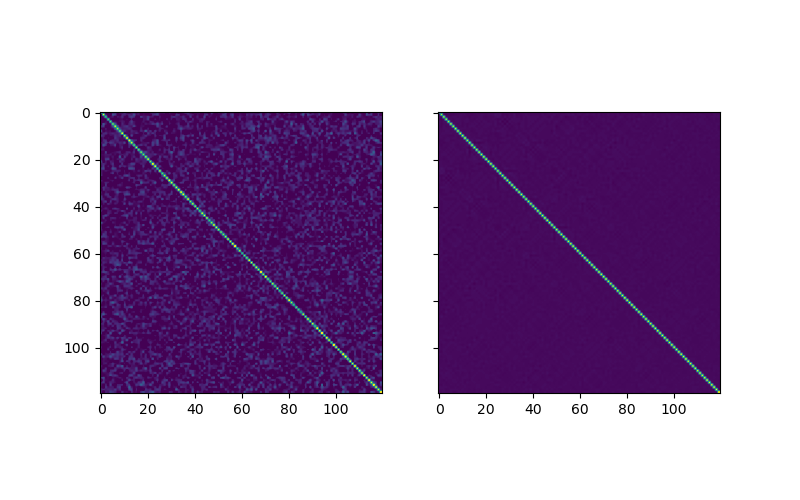

In [48]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 5), sharey=True, sharex=True)

axes[0].imshow(cov, vmin=A.min(), vmax=A.max())
axes[1].imshow(A)

In [50]:
ns = np.logspace(1, 2.7, 20)

diffs = [((A - np.cov([(DGi @ graph.U.T @ mu_inv(sample)).reshape(-1) for sample in model.sample(int(n))], rowvar=False)) ** 2).sum() for n in ns]

plt.figure()

plt.scatter(ns, diffs)

plt.yscale('log')

<IPython.core.display.Javascript object>

In [49]:
((A - cov) ** 2).sum()

136.31224779049882

In [288]:
fig, axes = plt.subplots(ncols=5, figsize=(10, 4), sharex=True, sharey=True)

axes[0].imshow(YY)
axes[1].imshow(model.compute_mean() > 0.5)

samples = model.sample(4)

for s, ax in zip(samples, axes[2:]):

    ax.imshow(s > 0.5)
    
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()

<IPython.core.display.Javascript object>

In [277]:
np.logspace(1, 2.7, 5)

array([ 10.   ,  26.607,  70.795, 188.365, 501.187])

In [227]:
ns = np.logspace(1, 2.7, 20)
diffs = [((A - np.cov([s.reshape(-1) for s in model.sample(int(n))], rowvar=False)) ** 2).sum() for n in ns]



<IPython.core.display.Javascript object>


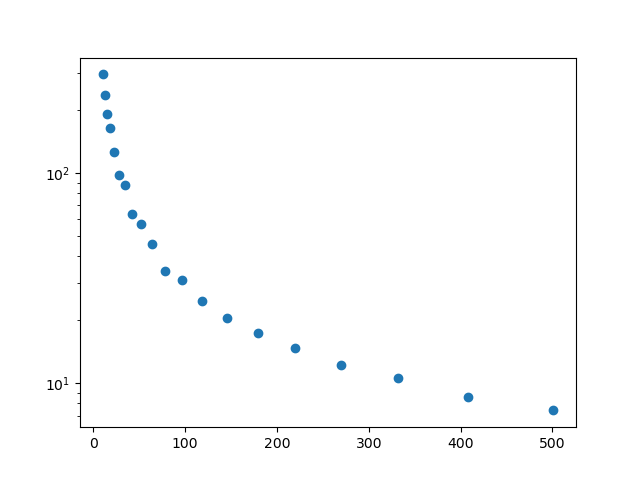

In [228]:
ns = np.logspace(1, 2.7, 20)
diffs = [((A - np.cov([s.reshape(-1) for s in model.sample(int(n))], rowvar=False)) ** 2).sum() for n in ns]

plt.figure()

plt.scatter(ns, diffs)

plt.yscale('log')

In [ ]:
((A - np.cov([s.reshape(-1) for s in model.sample(int(n))], rowvar=False)) ** 2).sum()

In [220]:
[[s for s in model.sample(int(n))] for n in ns]

KeyboardInterrupt: 

In [249]:
((A - np.cov([sample.reshape(-1) for sample in model.sample(100)], rowvar=False)) ** 2).sum()

31.656911227680297

In [206]:
for i in range(10):

    print(((A - np.cov([sample.reshape(-1) for sample in model.sample(50)], rowvar=False)) ** 2).sum())

53.99600381696202
52.32657982448582
55.48499340223886
55.477307214081705
55.1078403378732
61.59528980056568
57.45859410144619
61.08960002279733
58.87388410052248
58.70897753428731


In [151]:
Hi2 = graph.U @ KroneckerDiag(graph.get_G(filter_func) ** -2) @ graph.U.T
A = np.linalg.inv((Hi2 + KroneckerDiag(S)).to_array())
Y_mod2 = (A @ Y.reshape(-1)).reshape(Y.shape)

In [237]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4), sharex=True, sharey=True)

axes[0].imshow(np.cov([s.reshape(-1) for s in model.sample(100)], rowvar=False), vmin=A.min(), vmax=A.max())

axes[1].imshow(np.cov([s.reshape(-1) for s in model.sample(500)], rowvar=False), vmin=A.min(), vmax=A.max())

axes[2].imshow(A)

<IPython.core.display.Javascript object>

In [ ]:
plt.figure()



In [156]:
cov

array([[ 0.685,  0.127,  0.092, -0.02 , -0.013, ..., -0.013,  0.005,  0.013,  0.017,  0.011],
       [ 0.127,  0.373,  0.093,  0.015, -0.01 , ...,  0.021,  0.001,  0.016, -0.002,  0.006],
       [ 0.092,  0.093,  0.533,  0.098,  0.047, ...,  0.028,  0.029,  0.017, -0.01 , -0.011],
       [-0.02 ,  0.015,  0.098,  0.339,  0.048, ..., -0.001,  0.032,  0.009, -0.007, -0.013],
       [-0.013, -0.01 ,  0.047,  0.048,  0.395, ...,  0.004, -0.009,  0.004,  0.025, -0.029],
       ...,
       [-0.013,  0.021,  0.028, -0.001,  0.004, ...,  0.385,  0.029, -0.015, -0.002, -0.   ],
       [ 0.005,  0.001,  0.029,  0.032, -0.009, ...,  0.029,  0.364,  0.042, -0.023, -0.028],
       [ 0.013,  0.016,  0.017,  0.009,  0.004, ..., -0.015,  0.042,  0.348,  0.079,  0.04 ],
       [ 0.017, -0.002, -0.01 , -0.007,  0.025, ..., -0.002, -0.023,  0.079,  0.592,  0.12 ],
       [ 0.011,  0.006, -0.011, -0.013, -0.029, ..., -0.   , -0.028,  0.04 ,  0.12 ,  0.426]])

In [157]:
A

array([[ 0.676,  0.078,  0.003, -0.   , -0.   , ..., -0.   , -0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.078,  0.365,  0.071,  0.004, -0.   , ..., -0.   , -0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.003,  0.071,  0.565,  0.071,  0.002, ...,  0.   ,  0.   ,  0.   , -0.   ,  0.   ],
       [-0.   ,  0.004,  0.071,  0.364,  0.046, ...,  0.   ,  0.   ,  0.   , -0.   , -0.   ],
       [-0.   , -0.   ,  0.002,  0.046,  0.364, ..., -0.   ,  0.   ,  0.   ,  0.   , -0.   ],
       ...,
       [-0.   , -0.   ,  0.   ,  0.   , -0.   , ...,  0.361,  0.045,  0.001, -0.   , -0.   ],
       [-0.   , -0.   ,  0.   ,  0.   ,  0.   , ...,  0.045,  0.358,  0.045,  0.002, -0.   ],
       [ 0.   , -0.   ,  0.   ,  0.   ,  0.   , ...,  0.001,  0.045,  0.362,  0.071,  0.004],
       [ 0.   ,  0.   , -0.   , -0.   ,  0.   , ..., -0.   ,  0.002,  0.071,  0.565,  0.073],
       [ 0.   ,  0.   ,  0.   , -0.   , -0.   , ..., -0.   , -0.   ,  0.004,  0.073,  0.407]])

<IPython.core.display.Javascript object>


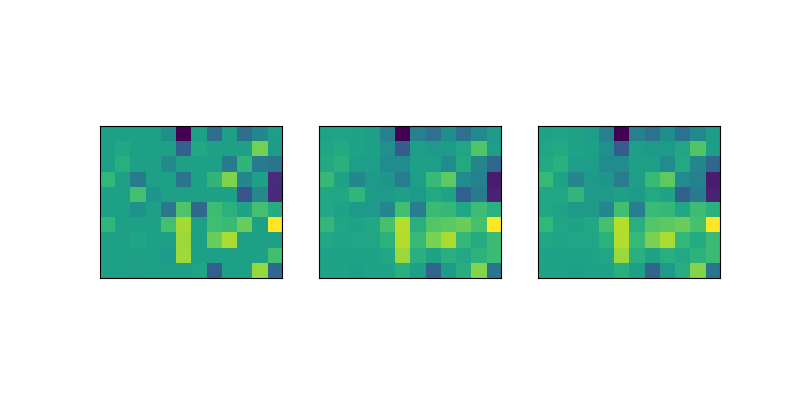

In [148]:
fig, axes = plt.subplots(ncols=3, figsize=(8, 4))


axes[0].imshow(Y)

axes[1].imshow(Y_mod)

axes[2].imshow(Y_mod2)

for ax in axes:
    
    ax.set_xticks([])
    ax.set_yticks([])

In [43]:
T = 5
N = 4

K = np.exp(-(np.linspace(0, 1, T)[:, None] - np.linspace(0, 1, T)[None, :]) ** 2)

A = np.random.uniform(0, 1, (N, N))

S = A @ A.T

In [48]:
fig, axes = plt.subplots(ncols=3)

axes[0].imshow(K)
axes[1].imshow(S)
axes[2].imshow(np.kron(K, S))

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

<IPython.core.display.Javascript object>

In [68]:
sample = np.random.multivariate_normal(mean=np.zeros(N * T), cov=np.kron(K, S)).reshape(T, N)

<IPython.core.display.Javascript object>


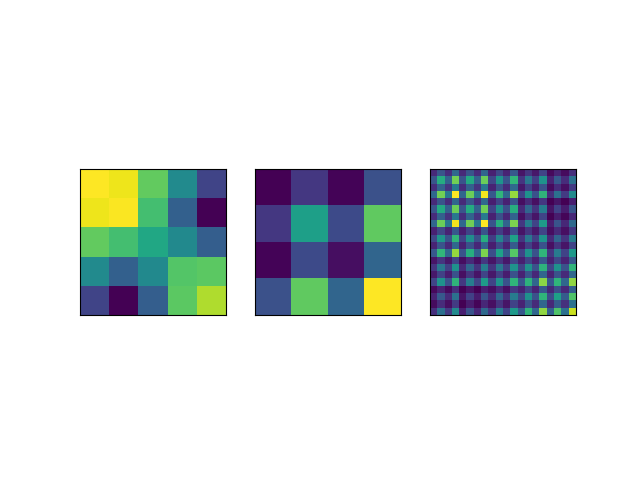

In [70]:
fig, axes = plt.subplots(ncols=3)


axes[0].imshow(np.cov(sample))
axes[1].imshow(np.cov(sample, rowvar=False))
axes[2].imshow(np.kron(np.cov(sample), np.cov(sample, rowvar=False)))

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

In [8]:
from ndgsp.graph.graphs import Graph, ProductGraph
from ndgsp.graph.filters import UnivariateFilterFunction

In [111]:
from pykronecker import KroneckerDiag, KroneckerIdentity, KroneckerBlock, KroneckerBlockDiag

In [110]:
N1 = 10
N2 = 10
N = N1 * N1
M = 5

In [3]:
g = ProductGraph.lattice(N1, N1)

In [9]:
X = np.random.normal(size=(N, M))

fil = UnivariateFilterFunction.diffusion(1)

In [18]:
DS = KroneckerDiag(np.random.randint(0, 2, (N1, N2)))

In [15]:
LG = KroneckerDiag(fil(g.lam))

In [32]:
lamX, Psi = np.linalg.eigh(X.T @ DS @ X)

In [72]:
DX = np.diag((lamX + 1) ** -0.5)

In [74]:
B = 

In [84]:
gamma = 0.5

In [115]:
M11 = LG @ g.U.T @ DS @ g.U @ LG + gamma * KroneckerIdentity(like=LG)
M12 = LG @ g.U.T @ DS @ X @ Psi @ DX

A = KroneckerBlock([[M11, M12], [M12.T, np.eye(5)]])

In [112]:
M_ = KroneckerBlock([[LG @ g.U.T @ DS, np.zeros((N, M))], [DX @ Psi.T @ X.T @ DS, np.zeros((M, M))]]) \
   @ KroneckerBlock([[DS @ g.U @ LG, DS @ X @ Psi @ DX], [np.zeros((M, N)), np.zeros((M, M))]]) \
   + KroneckerBlockDiag([gamma * KroneckerIdentity(like=LG), DX ** 2])

In [113]:
M_.to_array()

array([[ 3.592,  0.05 , -0.066, -0.011,  0.003, ..., -0.131,  0.037,  0.012,  0.088, -0.111],
       [ 0.05 ,  3.459,  0.013, -0.03 , -0.004, ..., -0.01 , -0.027,  0.063, -0.088, -0.022],
       [-0.066,  0.013,  3.359,  0.022,  0.015, ..., -0.016, -0.047, -0.046, -0.077, -0.121],
       [-0.011, -0.03 ,  0.022,  3.242, -0.004, ...,  0.011,  0.007, -0.003,  0.001, -0.001],
       [ 0.003, -0.004,  0.015, -0.004,  3.193, ..., -0.029, -0.035,  0.005,  0.002,  0.005],
       ...,
       [-0.131, -0.01 , -0.016,  0.011, -0.029, ...,  1.   , -0.   , -0.   , -0.   , -0.   ],
       [ 0.037, -0.027, -0.047,  0.007, -0.035, ..., -0.   ,  1.   , -0.   ,  0.   ,  0.   ],
       [ 0.012,  0.063, -0.046, -0.003,  0.005, ..., -0.   , -0.   ,  1.   ,  0.   ,  0.   ],
       [ 0.088, -0.088, -0.077,  0.001,  0.002, ..., -0.   , -0.   ,  0.   ,  1.   ,  0.   ],
       [-0.111, -0.022, -0.121, -0.001,  0.005, ...,  0.   ,  0.   ,  0.   ,  0.   ,  1.   ]])

In [116]:
A.to_array()

array([[ 3.592,  0.05 , -0.066, -0.011,  0.003, ..., -0.131,  0.037,  0.012,  0.088, -0.111],
       [ 0.05 ,  3.459,  0.013, -0.03 , -0.004, ..., -0.01 , -0.027,  0.063, -0.088, -0.022],
       [-0.066,  0.013,  3.359,  0.022,  0.015, ..., -0.016, -0.047, -0.046, -0.077, -0.121],
       [-0.011, -0.03 ,  0.022,  3.242, -0.004, ...,  0.011,  0.007, -0.003,  0.001, -0.001],
       [ 0.003, -0.004,  0.015, -0.004,  3.193, ..., -0.029, -0.035,  0.005,  0.002,  0.005],
       ...,
       [-0.131, -0.01 , -0.016,  0.011, -0.029, ...,  1.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.037, -0.027, -0.047,  0.007, -0.035, ...,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ],
       [ 0.012,  0.063, -0.046, -0.003,  0.005, ...,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ],
       [ 0.088, -0.088, -0.077,  0.001,  0.002, ...,  0.   ,  0.   ,  0.   ,  1.   ,  0.   ],
       [-0.111, -0.022, -0.121, -0.001,  0.005, ...,  0.   ,  0.   ,  0.   ,  0.   ,  1.   ]])

In [125]:


for 

6.1356045755395865

In [128]:
tspace = np.linspace(5, 500, 20)
ks = []

for T in tspace:
    
    x = np.linspace(0, 2, int(T))[:, None]

    K = np.exp(-(x - x.T) ** 2)

    ks.append(np.linalg.eigh(K)[0][-1])

<IPython.core.display.Javascript object>


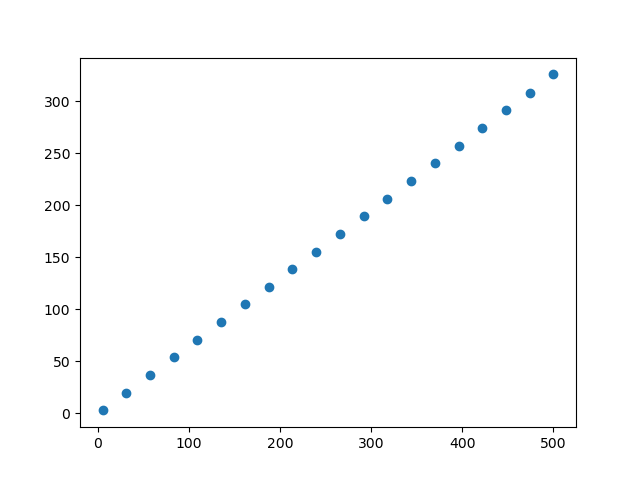

In [131]:
plt.figure()

plt.scatter(tspace, ks)